In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<!--
<span style="font-size:2em;">A Richer Knowledge Base for LLMs using mRAG</span> 


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/Fady-Ibra/RAG/blob/master/mRAG.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FFady-Ibra%2FRAG%2Fmasterm%2FRAG.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/Fady-Ibra/RAG/mRAG.ipynb.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/Fady-Ibra/RAG/master/mRAG.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>    
</table>
-->

- Authors: [Lavi Nigam](https://github.com/lavinigam-gcp) & [Fady Ibrahim](https://github.com/Fady-Ibra)
- Forked from: [Google Cloud Gen AI Repo](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/qa-ops/building_DIY_multimodal_qa_system_with_mRAG.ipynb)

# What We will Do

## Overview
- We'll create a QA sys that understands both text and images
- We'll build this system using Vertex AI

* **Focus on Fundamentals**: We will start with the essential design pattern of "Retrieval Augmented Generation" (RAG) – a way to find and use relevant info to answer questions.
* **Work with Text and Images**: We will expand RAG to handle both text and images found in PDF documents.
* **Use Vertex AI**: We will use Vertex AI Embeddings API and Vertex AI Gemini API.

By the end of this guide, we will have a solid foundation in building multimodal QA systems.

## Gemini
- Gemini is a family of GenAI models that is designed for multimodal use cases. 
- The Vertex AI Gemini API gives us access to:
    - Gemini 1.0 Pro Model
    - Gemini 1.0 Pro Vision Model
    - Gemini 1.5 Pro Model
    - Gemini 1.5 Flash Model

## Comparing text-based and mRAG
Multimodal RAG (mRAG) offers several advantages over text-based RAG:
1. **Enhanced knowledge access:** mRAG can access and process both textual and visual info, providing a richer and more comprehensive knowledge base for the LLM.
2. **Improved reasoning capabilities:** By incorporating visual cues, mRAG can make better informed inferences across different types of data modalities.

## How to implement RAG 
We will implement RAG using:
- Vertex AI Gemini API
- Vertex AI Embeddings API
  - [text embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-embeddings)
  - [multimodal embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/multimodal-embeddings), to build a doc search engine.

## Objectives
This notebook provides a guide to building a doc search engine using mRAG, step by step:
1. Extract and store metadata of docs containing both text and images, and generate embeddings the docs
2. Search the metadata with text queries to find similar text or images
3. Search the metadata with image queries to find similar images
4. Using a text query as input, search for contextual answers using both text and images

## Costs
- [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing)
- [Pricing Calculator](https://cloud.google.com/products/calculator) (generates a cost estimate)


# Getting Started
## Install Vertex AI SDK and other dependencies
**Next Command Explanation**
- **!** to execute a command
- **pip3** a Python Package Manager (with a recursive acronym PIP Installs Packages)
- **--upgrade (-U)** INSTALL OPTIONS upgrade all packages to the newest available version
- **--user** install packages in the user home directory (pip defaults to installing Python packages to a sys directory, as /usr/local/lib/python3.4, which requires root access)

In [2]:
!pip3 install --upgrade --user google-cloud-aiplatform | grep -v "already satisfied"
!pip3 install --upgrade --user pymupdf                 | grep -v "already satisfied"
!pip3 install --upgrade --user rich                    | grep -v "already satisfied"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 19.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.60.0
    Uninstalling google-cloud-aiplatform-1.60.0:
      Successfully uninstalled google-cloud-aiplatform-1.60.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires grpcio!=1.48.0,<2,>=1.33.1, but you have grpcio 1.48.0 which is incompatible.
google-cloud-pubsub 2.21.4 requires grpcio<2.0dev,>=1.51.3, but you have grpcio 1.48.0 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tens

### Restart the kernel
- To use the newly installed packages, we must restart the kernel. 
- Restarting the kernel after installs so that our environment can access the new packages
- To know more about the kernel, please check the image below ([image source](https://ipython.org/ipython-doc/3/development/how_ipython_works.html)).
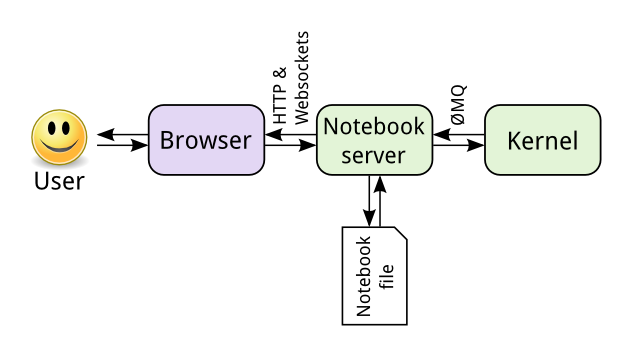

## Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [3]:
import sys
    
if "google.colab" in sys.modules:
    print("I am in Colab")
    from google.colab import auth
    auth.authenticate_user() # Authenticate user to Google Cloud

## Define Google Cloud project information


In [4]:
import sys

PROJECT_ID = ""  
LOCATION = "us-central1" 

# if not running on Colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    CMD_OUTPUT = !gcloud config get-value project
    PROJECT_ID = CMD_OUTPUT[0]

print(f"Cmd Output: {CMD_OUTPUT}")
print(f"Project ID: {PROJECT_ID}")

Cmd Output: ['ai-gcp-demos']
Project ID: ai-gcp-demos


In [5]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Load Gemini models

In [6]:
from vertexai.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingModel
from vertexai.vision_models import MultiModalEmbeddingModel

# Text model: works with: 
#   1) text, code
model_10p   = GenerativeModel("gemini-1.0-pro") 

# Multimodal models: works with 
#   1) text, code, 
#   2) video(without audio), and 
#   3) images 
# with 16k input context
model_10pv  = GenerativeModel("gemini-1.0-pro-vision-001") 

# Multimodal models: works with 
#   1) text, code, 
#   2) images, 
#   3) video(with or without audio) and 
#   4) audio(mp3) 
# with 2M or 1M input context 
# Choose based on performance/cost needs
model_15p = GenerativeModel("gemini-1.5-pro-001")   
model_15f = GenerativeModel("gemini-1.5-flash-001") 

# Load text embedding model from pre-trained source
model_tEMB = TextEmbeddingModel.from_pretrained("text-embedding-004")

# Load multimodal embedding model from pre-trained source
# works with 
#   1) image, 
#   2) image with caption(~32 words), 
#   3) video, 
#   4) video with caption(~32 words)
model_mEMB = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")

## Get documents and images from GCS
**gcloud storage rsync**
makes the contents under the destination the same as the contents under the source, by
- copying any missing files/objects (or those whose data has changed), and 
- (if the -d option is specified) deleting any extra files/objects

**Options of the command:**
- **--quiet (-q)** Top-level option for the gcloud CLI that disables all interactive prompts when running gcloud CLI commands and is useful for scripting. 
- **-r** to copy an entire directory tree

In [7]:
# download documents and images used in this notebook
!gcloud -q storage rsync -r gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2 .
#!rm -f data/Google\ Cloud\ TPU\ blog.pdf
!rm -f data/med_gemini.pdf

At file://./**, worker process 107033 thread 140185273149248 listed 43...
At gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/**, worker process 107033 thread 140185273149248 listed 90...
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/data/med_gemini.pdf to file://./data/med_gemini.pdf
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/images/Google Cloud TPU blog.pdf_image_11_0_62.jpeg to file://./images/Google Cloud TPU blog.pdf_image_11_0_62.jpeg
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/images/Google Cloud TPU blog.pdf_image_11_1_63.jpeg to file://./images/Google Cloud TPU blog.pdf_image_11_1_63.jpeg
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/images/Google Cloud TPU blog.pdf_image_12_0_66.jpeg to file://./images/Google Cloud TPU blog.pdf_image_12_0_66.jpeg
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/images/Google Cloud TPU b

# Building metadata of documents containing text and images

## The data
The source data that we will use in this notebook are:

* [Google Cloud TPU Scaling blog](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/Google%20Cloud%20TPU%20blog.pdf)
* [Gemini 1.5 Technical Report](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/gemini_v1_5_report_technical.pdf)
* [Google Gemma Technical Paper](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/gemma_technical_paper.pdf)
* [Med-Gemini Technical Paper](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/med_gemini.pdf)

We can also use other data, by deleting the current files and then placing new files in the `data` folder

## Extract and store metadata of text and images from a document
- The function `get_document_metadata()` extracts text and image metadata from a document, and returns two dataframes, namely *text_metadata* and *image_metadata*. 
- To know more about how `get_document_metadata()` is implemented using Gemini and the embedding models, please check the [source code](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py).

- At the next step, we will use the function to extract and store metadata of text and images from a document. 
- NOTE: We are loading 4 files with roughly 200 pages and approximately 84 images, the cell below  may take a few minutes to complete. We recommend loading pre-computed metadata instead.


In [8]:
import time
from vertexai.generative_models import GenerationConfig, HarmCategory, HarmBlockThreshold
from multimodal_qa_with_rag_utils import get_document_metadata
from multimodal_qa_with_rag_utils import set_global_variable

set_global_variable("text_embedding_model", model_tEMB)
set_global_variable("multimodal_embedding_model", model_mEMB) 

In [ ]:
%%time          
                # Cell Magic Command %%time to output the execution time of the entire cell

image_description_prompt = """
- You are a technical image analysis expert. 
- You will be provided with various types of images extracted from docs.
- This docs include research papers, technical blogs, and more.
- Your task is to generate concise, accurate descriptions of the images.
- Please do not add any info you are not confident about.
- Focus on capturing the key details, trends, or relationships depicted in the images.

Important Guidelines:
* Prioritize accuracy:  If you are uncertain about any detail, state "Not visible" instead of guessing.
* Avoid hallucinations: Do not add info that is not directly supported by the image.
* Be specific:          Use precise language to describe shapes, colors, textures, and any interactions depicted.
* Consider context:     If the image is a screenshot or contains text, incorporate that info into description.
"""

safety_settings = {
    HarmCategory.HARM_CATEGORY_HARASSMENT:        HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH:       HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
}


# Remove pre-exsisting images folder (here we are running the logic from scratch)
!rm -rf images/ 

# Extract text and image metadata from the PDF docs
text_metadata_df, image_metadata_df = get_document_metadata(
    model_15p,  
    pdf_folder_path           = "data",
    image_save_dir            = "images",
    embedding_size            = 1408,  # dimension must be one of 128, 256, 512, 1408.
    add_sleep_after_page      = True, 
    sleep_time_after_page     = 12,    # in seconds, increase value if getting quota issues
    add_sleep_after_document  = True, 
    sleep_time_after_document = 30,    # in seconds, increase value if getting quota issues
    image_description_prompt  = image_description_prompt,
    safety_settings           = safety_settings,        
    generation_config         = GenerationConfig(temperature=0.2, max_output_tokens=2048) #fady
)




 Processing the file: --------------------------------- data/gemini_v1_5_report_technical.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/gemini_v1_5_report_technical.pdf_image_0_0_1910.jpeg
Sleeping for  12  sec before processing the next page to avoid quota issues. You can disable it: "add_sleep_after_page = False"  
Processing page: 2
Sleeping for  12  sec before processing the next page to avoid quota issues. You can disable it: "add_sleep_after_page = False"  
Processing page: 3
Sleeping for  12  sec before processing the next page to avoid quota issues. You can disable it: "add_sleep_after_page = False"  
Processing page: 4
Sleeping for  12  sec before processing the next page to avoid quota issues. You can disable it: "add_sleep_after_page = False"  
Processing page: 5
Extracting image from page: 5, saved as: images/gemini_v1_5_report_technical.pdf_image_4_0_142.jpeg
Extracting image from page: 5, saved as: images/gemini_v1_5_report_technical.pdf_imag

We can check additional Gemini API parameters and safety setting while building metadata:
- [Gemini API parameters](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/gemini)
- [Safety settings and thresholds](https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/configure-safety-attributes)
- We can also pass parameters and safety setting to `get_gemini_response` function

## Load pre-computed metadata of text and images from source document
**If you are facing issues with Quota or want to focus on the outputs, we can load pre-computed metadata.**

In [ ]:
#To use this cell, uncomment by removing """ at the start and """ at the end
"""
import pickle

# Load the pickle file
with open("mrag_metadata.pkl", "rb") as f:
    data = pickle.load(f)

# Extract the DataFrames
print(type(data))
text_metadata_df = data["text_metadata"]
image_metadata_df = data["image_metadata"]
"""

### Inspect the processed text metadata


The following cell will produce a metadata table which describes the different parts of text metadata, including:

- **text**: the page text
- **text_embedding_page**: the embedding of the page text
- **chunk_text**: the page text divided into smaller chunks
- **chunk_number**: the index of each text chunk
- **text_embedding_chunk**: the embedding of each text chunk

In [ ]:
print(text_metadata_df.shape)
print("*****************************************************************************")
print(text_metadata_df.iloc[0, :]);
print("*****************************************************************************")
print(text_metadata_df.iloc[1, :]);
print("*****************************************************************************")

In [ ]:
print(text_metadata_df.iloc[0, :]["text"]);
print("*****************************************************************************")
print(text_metadata_df.iloc[0, :]["text_embedding_page"]);
print("*****************************************************************************")
print(type(text_metadata_df.iloc[0, :]["text_embedding_page"]));
print( len(text_metadata_df.iloc[0, :]["text_embedding_page"]));

In [ ]:
print(text_metadata_df.iloc[0, :]["chunk_text"]);
print("*****************************************************************************")
print(text_metadata_df.iloc[0, :]["text_embedding_chunk"]);
print("*****************************************************************************")
print(type(text_metadata_df.iloc[0, :]["text_embedding_chunk"]));
print( len(text_metadata_df.iloc[0, :]["text_embedding_chunk"]));

### Inspect the processed image metadata
The following cell will show the following metadata:
- **img_desc**: Gemini-generated textual description of the image
- **text_embedding_from_image_description**: text embedding of the generated textual description
- **mm_embedding_from_img_only**: image embedding

In [ ]:
print(image_metadata_df.shape)
print("*****************************************************************************")
print(image_metadata_df.iloc[0, :]);
print("*****************************************************************************")
print(image_metadata_df.iloc[1, :]);
print("*****************************************************************************")

In [ ]:
print(image_metadata_df.iloc[0, :].img_desc)
print("*****************************************************************************")
print(image_metadata_df.iloc[0, :].text_embedding_from_image_description)
print("*****************************************************************************")
print(type(image_metadata_df.iloc[0, :].text_embedding_from_image_description))
print( len(image_metadata_df.iloc[0, :].text_embedding_from_image_description))

In [ ]:
print(image_metadata_df.iloc[0, :].mm_embedding_from_img_only)
print("*****************************************************************************")
print(type(image_metadata_df.iloc[0, :].mm_embedding_from_img_only))
print( len(image_metadata_df.iloc[0, :].mm_embedding_from_img_only))

## Import the helper functions to implement RAG
We will import the following functions to implement RAG:
1) **get_similar_text_from_query():** 
    - Given a text query, finds text from the doc which are relevant. 
    - It uses text embeddings from the metadata
2) **print_text_to_text_citation():** 
    - Prints the source (citation) and details of the retrieved text.
3) **get_similar_image_from_query():** 
    - Given an image, finds images from the doc which are relevant. 
    - It uses image embeddings from the metadata.
4) **print_text_to_image_citation():** 
    - Prints the source (citation) and the details of retrieved images.
5) **get_gemini_response():** 
    - Interacts with a Gemini to answer questions based on text and image inputs.
6) **display_images():**  
    - Displays a series of images.

In [ ]:
from multimodal_qa_with_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    
    get_similar_image_from_query,
    print_text_to_image_citation,
    display_images,
    
    get_gemini_response,    
    get_answer_from_qa_system, 
)

- Before implementing a Multimodal QA Sys with Vertex AI, let's explore what we can achieve with just text or image embeddings. 
- This will set the foundation for implementing an mRAG Sys. 

# Text Search

## Search similar text with text query

In [ ]:
query = """
What are various med-gemini medical benchmarks that show its performance relative to other models?
"""

# Matche user text with "chunk_embedding" to find relevant chunks.
matching_results_text = get_similar_text_from_query(
    query, 
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=3,
)
print(type(matching_results_text))
print( len(matching_results_text))
for key, value in matching_results_text.items():
    print(f"{key}: {value}")
print("*****************************************************************************")
print_text_to_text_citation(matching_results_text, print_top=False)

## Get answer with RAG

In [ ]:
from rich.markdown import Markdown as rich_Markdown

# All relevant text chunk found across docs based on user query
all_chunk_text = [value["chunk_text"] for _, value in matching_results_text.items()]
print(type(all_chunk_text))
print( len(all_chunk_text))

context = "\n".join(all_chunk_text)

prompt = f"""
    Answer the question with the given context. 
    If the specific answer is not in the context, please answer "I don't know".
    Question: {query}
    Context: {context}
    Answer:
"""

In [ ]:
%%time
gemini_response = get_gemini_response(
    model_15p,        # Use Gemini 1.5 Pro
    model_input       = prompt,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)
rich_Markdown(gemini_response)

In [ ]:
%%time
gemini_response = get_gemini_response(
    model_15f,       # Use Gemini 1.5 Flash
    model_input       = prompt,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=2048),
)
rich_Markdown(gemini_response)

## Search similar images with text query based on image description
- Sometimes the Plain text search and RAG don't provide the detailed answer
- The info may be visually represented in a table or another image format
- The goal here also is to find an image similar to the text query
- We may also print the citations to verify

In [ ]:
matched_images = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query              = query,
    column_name        = "text_embedding_from_image_description", 
    image_emb          = False,  # Use text embedding instead of image embedding
    top_n              = 2,
)

print_text_to_image_citation(matched_images, print_top=False)
print("*****************************************************************************")
display_images(
    [matched_images[0]["img_path"], matched_images[1]["img_path"]],
    #resize_ratio=0.5,
)
print("*****************************************************************************")
print(type(matched_images))
print( len(matched_images))

## Get answer with RAG

In [ ]:
%%time

txt_prompt = f"""
    Answer the question and explain results with the given Images:
    Question: {query}
    Images:
"""

prompt = [
    txt_prompt,
    "Image:",       matched_images[0]["image_object"],
    "Description:", matched_images[0]["image_description"],
    "Image:",       matched_images[1]["image_object"],
    "Description:", matched_images[1]["image_description"],
]

gemini_response = get_gemini_response(
    model_15p,        # Use Gemini 1.5 Pro
    model_input       = prompt,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)
rich_Markdown(gemini_response)

# Image Search
## Search similar image with image input 
- For demonstration, we will only find similar images in a single doc
- However, we can scale to match (find relevant images) across multiple docs

In [ ]:
image_query_path = "images/gemini_v1_5_report_technical.pdf_image_4_0_142.jpeg"
display_images([image_query_path]) 

In [ ]:
# Search for similar images based on input image and Image Embedding

matched_images = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query              = query,
    column_name        = "mm_embedding_from_img_only",
    image_emb          = True, #Previous: False
    image_query_path   = image_query_path, 
    embedding_size     = 1408, 
    top_n              = 2,
)
print_text_to_image_citation(matched_images, print_top=True)   
print("*****************************************************************************")
display_images([matched_images[0]["img_path"]]) 

## Another Example
In this example, we will do the following:
1) Search all the images for a specific query
2) Send those images to Gemini 1.5 Pro to ask multiple questions, where it has to compare among those images and provide answers

In [ ]:
matched_images = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query              = "Show me all the images that can describe LLMs and TPU v5e scaling",
    column_name        = "text_embedding_from_image_description", 
    image_emb          = False,    
    top_n              = 2,
)
print_text_to_image_citation(matched_images, print_top=False)
print("*****************************************************************************")
display_images([ 
    matched_images[0]["img_path"], 
    matched_images[1]["img_path"]
])

In [ ]:
%%time

query = """
 - How does the scaling efficiency of TPU v5e compare to the overall growth in LLM model size over time?
 - How does the model size impact the observed Per-chip performance and EMFU 
    for a fixed number of TPU v5e chips (e.g., 256)?
 - For the INT8 Quant training with 32B parameters, 
    how does its high EMFU relate to the observed TFLOP/chip/s?
 - How does the "per device batch (seq)" for a 16B model compare to a 128B model, 
    and how does this affect the "Total observed Perf"?
 - How might the MFU be impacted by increasing LLM model size?
 """

txt_prompt = f"""
Task: Answer the following questions in detail, 
providing clear reasoning and evidence from the images in bullet points.

Instructions:
1. Analyze the provided images focusing on the relationship between 
       a) TPU v5e scaling efficiency, 
       b) LLM model size growth, 
       c) performance metrics, and 
       d) quantization effects.
2. Answer the following questions in detail, 
       providing clear reasoning and evidence from the images in bullet points
3. Cite the image sources to support your explanations. Mention the file name.

Additional Considerations:
* Clearly define any technical terms within your answers for better understanding.
* Use specific examples and data points from the images to support your explanations.
* Feel free to request additional info or clarification if the images are unclear or ambiguous.

Question:
{query}

"""

prompt = [
    txt_prompt,
    "Images:",  matched_images[0]["image_object"], matched_images[1]["image_object"],
]

gemini_response = get_gemini_response(
    model_15p,        # Use Gemini 1.5 Pro
    model_input       = prompt,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)
rich_Markdown(gemini_response)

# Building Multimodal QA System with mRAG

Let's bring everything together to implement multimodal RAG. We will use all the elements that we have explored in previous sections to implement the multimodal RAG. These are the steps:

1) The user gives a query in text format where the expected info is available in the docs.
2) Find all text chunks from the pages in the docs.
3) Find all similar images from the pages based on the user query.
4) Combine all similar text and images found in steps 2 and 3.
5) With the help of Gemini, we can pass the user query with text and image context. We can also add a specific instructions the model should remember while answering the user query.
6) Gemini produces the answer, and we can print the citations to check all relevant text and images used to address the query.

## Step 1: User query

In [ ]:
# this time we are not passing any images, but just a simple text query.
print(query)

## Step 2: Get all relevant text chunks

In [ ]:
matched_text = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name      = "text_embedding_chunk",
    top_n            = 20,
)

## Step 3: Get all relevant images

In [ ]:
matched_images = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query       = query,
    column_name = "text_embedding_from_image_description",
    image_emb   = False,
    top_n       = 10,
)

## Step 4: Create context_text and context_images

In [ ]:
txt_prompt = """
Task: Answer the following questions in detail, 
        providing clear reasoning and evidence from the images and text in bullet points.

Instructions:
1. **Analyze:** Carefully examine the provided images and text context.
2. **Synthesize:** Integrate information from both the visual and textual elements.
3. **Reason:**  Deduce logical connections and inferences to address the questions.
4. **Respond:** Provide a concise, accurate answers in the following format:
   * **Question:** [Question]
   * **Answer:** [Direct response to the question]
   * **Explanation:** [Bullet-point reasoning steps if applicable]
   * **Source** [name of the file, page, image from where the information is citied]

5. **Ambiguity:** If the context is insufficient to answer, respond "Not enough context to answer."

"""

prompt = [
    txt_prompt,
    "Questions: ", query,
    "Image Context: ",
]
for _, value in matched_images.items():
    prompt.extend([
        "Image Path: ",        value["img_path"],
        "Image Description: ", value["image_description"],
        "Image:",              value["image_object"],
    ])

text_context = ["Text Context: "]
for key, value in matched_text.items():
    text_context.extend([
        "Text Source: ", f"""file_name: "{value["file_name"]}", Page: "{value["page_num"]}" """,
        "Text:",      value["chunk_text"],
    ])
    
prompt.extend(text_context)

## Step 5: Pass context to Gemini

In [ ]:
gemini_response = get_gemini_response(
    model_15p,        # Use Gemini 1.5 Pro
    model_input       = prompt, 
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)
rich_Markdown(gemini_response)

## Step 6: Print citations and references [Optional]

In [ ]:
display_images([
    matched_images[0]["img_path"],
    matched_images[1]["img_path"],
    matched_images[2]["img_path"],
    matched_images[3]["img_path"],
    matched_images[5]["img_path"],
])

In [ ]:
print_text_to_image_citation(matched_images, print_top=True)

In [ ]:
print_text_to_text_citation(matched_text, print_top=True)

# More questions with Multimodal QA System

In [ ]:
# this time we are not passing any images, but just a simple text query.

query = """
Question 1: 
Imagine a patient presents with new onset prurigo nodularis.
Could Med-Gemini-M 1.5 be used to analyze dermatological images 
  of the patient's lesions in conjunction with a comprehensive history taken
  from an EHR dialogue to help a clinician reach a diagnosis and develop a treatment plan?
What are the limitations and potential ethical considerations of using the model in this way?

Question 2: 
The paper focuses on uncertainty-guided search for text-based reasoning tasks.
How could this approach be extended to multimodal tasks?
For instance, if Med-Gemini-M 1.5 encounters uncertainty when analyzing a dermatology image, 
  could it generate queries to search for 
  relevant visual examples or supplemental clinical info to refine its interpretation?

Question 3:  
Considering the potential benefits and risks highlighted in the paper, 
  what specific steps should be taken during the development, validation, and deployment 
  of Med-Gemini models to ensure they are used safely, fairly, and effectively 
  in real-world clinical settings?
How can these steps be informed by ongoing collaboration between 
 researchers, clinicians, regulators, and patient communities?
"""

(response, matched_text, matched_images) = get_answer_from_qa_system(
    query,
    text_metadata_df,
    image_metadata_df,
    top_n_text        = 10,
    top_n_image       = 5,
    model             = model_15p,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)

rich_Markdown(response)

In [ ]:
query = """
Question 1: 
How does the mixture-of-experts architecture in Gemini 1.5 Pro contribute to 
  its ability to handle long context while maintaining performance on core capabilities? 
Discuss the potential trade-offs involved.

Question 2: 
Gemini 1.5 Pro incorporates various safety mitigations, 
  including supervised fine-tuning and reinforcement learning.
Discuss the effectiveness of these mitigations 
  in addressing content safety and representational harms in both text-to-text and
image-to-text modalities. How can these evaluations be improved?

Question 3: 
Gemini 1.5 Pro demonstrates surprising in-context language learning capabilities for Kalamang,
  a low-resource language. 
What are the implications of this finding for language preservation and revitalization?
What challenges need to be addressed for broader applicability of this approach?
"""

(response, matched_text, matched_images) = get_answer_from_qa_system(
    query,
    text_metadata_df,
    image_metadata_df,
    top_n_text        = 10,
    top_n_image       = 5,
    model             = model_15p,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)

rich_Markdown(response)